# Restaurant Visitor Forecasting


### Introduction

Being able to predict restaurant visits accuractly is a neat application of forecasting techniques. In this case, we have the data for visits for a restaurant on a daily basis for 1+ years. From an analytic standpoint, a more nuanced version of forecasting will be attempted, one which incorporates exogenous variables. 

This data is an adapted version of a recently concluded competition on Keggle. [more detials](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/data) 

### Goal

To forecast the daily restaurant visits for a 60 day duration.


### Result Summary
SARIMAX is the best performing model *(RMSE of 28.65)* followed by Holt-Winters model *(RMSE of 29.79)*


### Notable Mention: Awesomeness of Holt-Winter's
In my experience with implementing forecasting techniques, Holt-Winter's method has consistently performed well. I decided to dig deeper and came across this paper: [Why the damped trend works by Everette S. Gardner, Jr. and Eddie McKenzie](https://www.bauer.uh.edu/gardner/docs/pdf/Why-the-damped-trend-works.pdf)

The context of this paper is mentioned below (quoting from the paper):

> In forecasting with exponential smoothing, it is common to apply the damped trend
method to every time series, although many attempts have been made to improve on this practice
by selecting individual methods for each series. Examples include selection based on
information criteria (Hyndman et al, 2008), expert systems (Flores and Pearce, 2000), and time
series characteristics (Gardner and McKenzie, 1988). Although method selection procedures can
result in simpler methods than the damped trend, they have yet to produce better forecast
accuracy


### Table of Contents
1. Getting and setting-up the data
2. Data Exploration 
3. A baseline model using Holt-Winters Method (Triple Exponential Smoothening)
4. An Seasonal ARIMA with Exogenous variables based Model
5. Summary

***

### 1. Getting and Setting-up Data

In [3]:
# Initial Housekeeping

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Restaurant_visitor"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

#create the reqired folders if they don't already exist
os.makedirs(IMAGES_PATH, exist_ok=True)

# A simple function that helps save images
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)



In [78]:
# Housekeeping, Part 2

# to make the plots larger in size
from pylab import rcParams
rcParams['figure.figsize'] = 16,10


# A set of libraries pertaining to forecasting methods

from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.filters.hp_filter import hpfilter

from sklearn.metrics import mean_squared_error

In [5]:
# Getting the data

df = pd.read_csv("/Users/ramavishwanathan/Desktop/Rama Files/purse/ml_all/ML_Projects/datasets/time_series/RestaurantVisitors.csv", index_col = 'date', parse_dates = True)

In [6]:
# having a quick look at the data
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


In [7]:
df.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [8]:
df = df.dropna()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 478 entries, 2016-01-01 to 2017-04-22
Data columns (total 8 columns):
weekday         478 non-null object
holiday         478 non-null int64
holiday_name    478 non-null object
rest1           478 non-null float64
rest2           478 non-null float64
rest3           478 non-null float64
rest4           478 non-null float64
total           478 non-null float64
dtypes: float64(5), int64(1), object(2)
memory usage: 33.6+ KB


So, we are looking to forecast the `total` column.

In [13]:
# Converting the float columns to numeric
cols = ['rest1', 'rest2', 'rest3','rest4', 'total']

In [14]:
for i in cols:
    df[i] = df[i].astype(int)

In [11]:
df.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2017-04-13', '2017-04-14', '2017-04-15', '2017-04-16',
               '2017-04-17', '2017-04-18', '2017-04-19', '2017-04-20',
               '2017-04-21', '2017-04-22'],
              dtype='datetime64[ns]', name='date', length=478, freq=None)

In [23]:
# Important Step

df.index.freq = 'D'

***

### 2. Data Exploration

Plotting the data, performing the ETS decomposition and exploring Stationarity. 

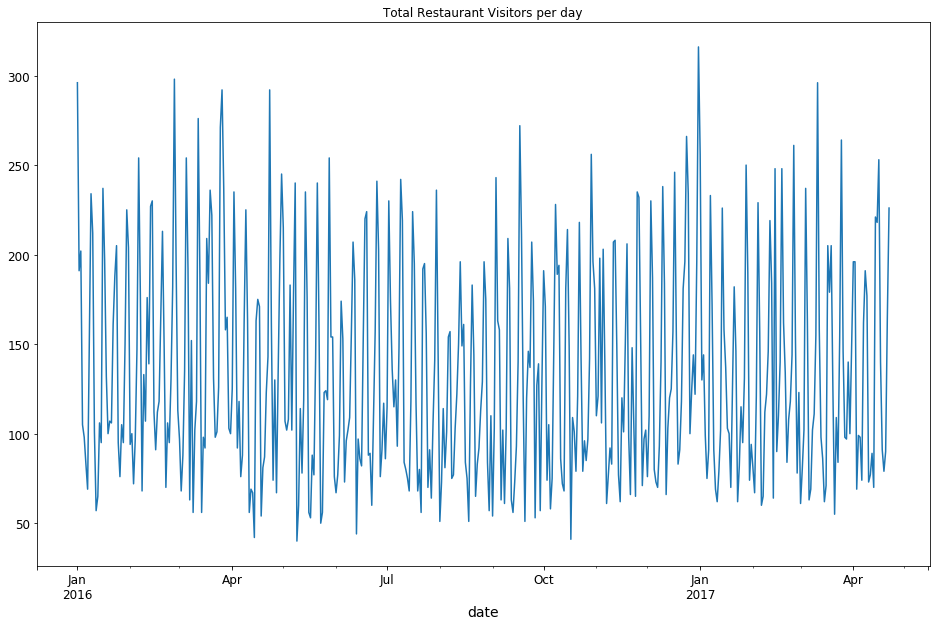

In [12]:
# Plotting the data
df['total'].plot(title = "Total Restaurant Visitors per day")

In [15]:
# average visits on a holiday vs. a non hliday
df[['total','holiday']].groupby('holiday').mean()

,total
holiday,
0,129.493274
1,193.718750


There is **significance difference** between the average Holiday and Non-Holiday visits.

Before we go any further along the analysis,we will divide the data into training and testing sets. The last 60 days of data will be set aside for validation purposes i.e. testing set.

In [25]:
train = df.iloc[:418]
test = df.iloc[418:]

test.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2017-02-22 to 2017-04-22
Freq: D
Data columns (total 8 columns):
weekday         60 non-null object
holiday         60 non-null int64
holiday_name    60 non-null object
rest1           60 non-null int64
rest2           60 non-null int64
rest3           60 non-null int64
rest4           60 non-null int64
total           60 non-null int64
dtypes: int64(6), object(2)
memory usage: 4.2+ KB


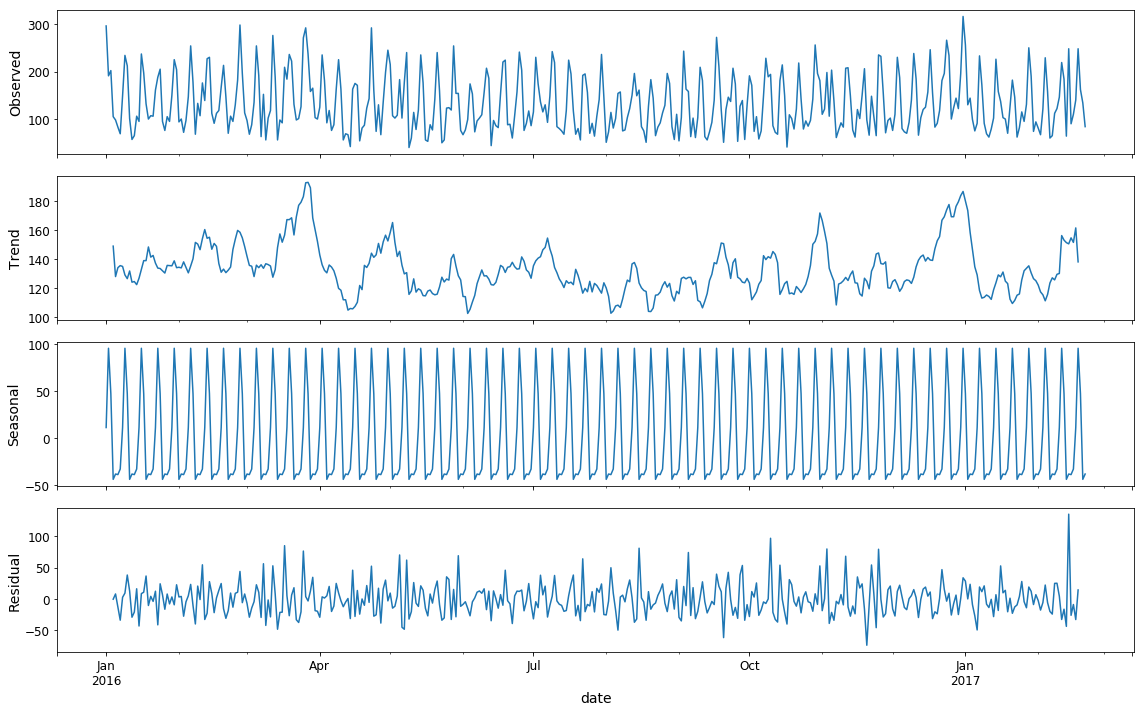

In [18]:
# Seasonal Decompose to get ETS components
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(train['total'], model = 'add')
result.plot();

There is a **significant degree of seasonality** in the data.

Next up, we will be evaluating stationarity by performing the Augmented Dickey Fuller Test.

In [19]:
# Augmented Dickey Fuller Test

# RUN AUGMENTED D-F TEST TO TEST FOR STATIONARITY
# using that kickass tool which was developed earlier by us
# *********************************************************

# A CUSTOM FUNCTION TO INTERPRET THE RESULTS OF THE AUGMENTED D-F TEST

def adf_test(series,title=''):
    """
    Input: 
          Pass in a time series and an optional title, 
    Returns, an ADF report
    """
    
    print("*******************************************")
    print(f'Augmented Dickey-Fuller Test: {title}')
    print("\n")
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    print("\n")
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
    print("*******************************************")


In [20]:
adf_test(train['total'])

*******************************************
Augmented Dickey-Fuller Test: 


ADF test statistic       -5.160232
p-value                   0.000011
# lags used              18.000000
# observations          399.000000
critical value (1%)      -3.446846
critical value (5%)      -2.868811
critical value (10%)     -2.570643


Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
*******************************************


The data is stationary.

***

### 3. A Baseline Model using Holt-Winter's Method

Starting off by implementing the Holt's method first, which does not account for seasonality.

#### Holt's Method - Double Exponential Smoothening
Using `trend` as additive

In [27]:
double_exp_model = ExponentialSmoothing(train['total'],trend = 'add')

fitted_model_DES = double_exp_model.fit()

train['DES_model'] = fitted_model_DES.fittedvalues.shift(-1)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


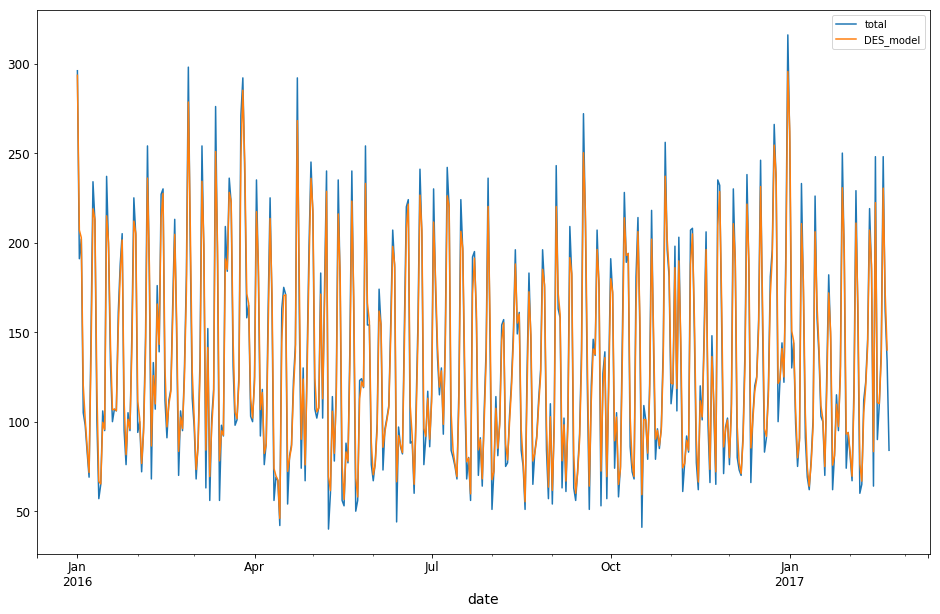

In [28]:
# Plotting the DES model against the original data
train[['total','DES_model']].plot(legend = True)

The predictions seem good for the most part except for the extreme values. 

To understand if the 'mis-predictions' are aligned with the holiday data, we will be plotting the holiday data alongside.

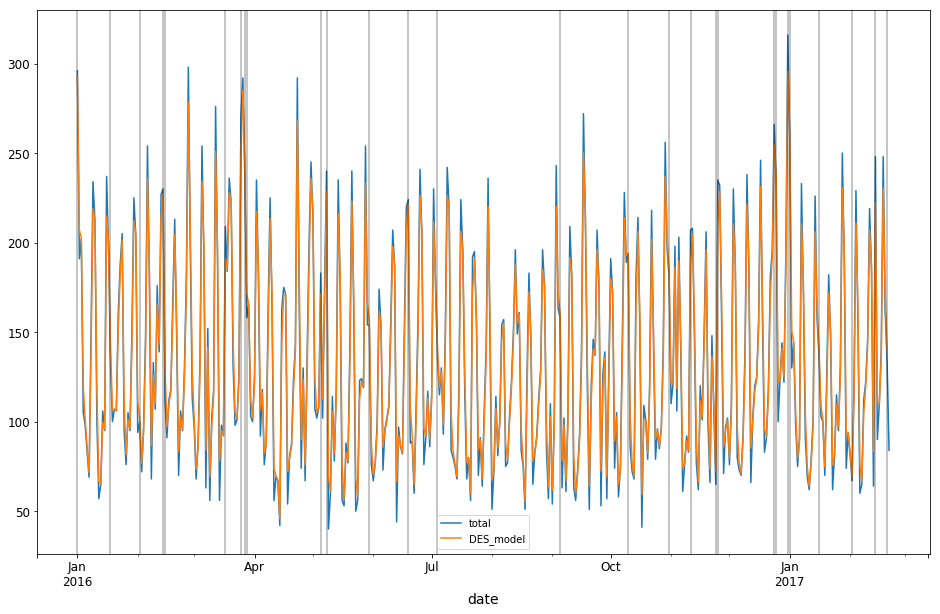

In [30]:

ax= train[['total','DES_model']].plot(legend = True)


for day in train.query('holiday ==1').index:
    ax.axvline(x=day, color = 'black', alpha = 0.3);

The Double Exponential Smoothing results looks reasonably well.

#### Holt Winter's Method - Triple Exponential Smoothening

Using `trend` and `seasonality` as *additive*. Setting the number of `seasonal_periods` as 7 (weekly)

In [31]:
triple_exp_model = ExponentialSmoothing(train['total'],trend = 'add', seasonal = 'add', seasonal_periods = 7)

fitted_model_TES = triple_exp_model.fit()

train['TES_model'] = fitted_model_TES.fittedvalues


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


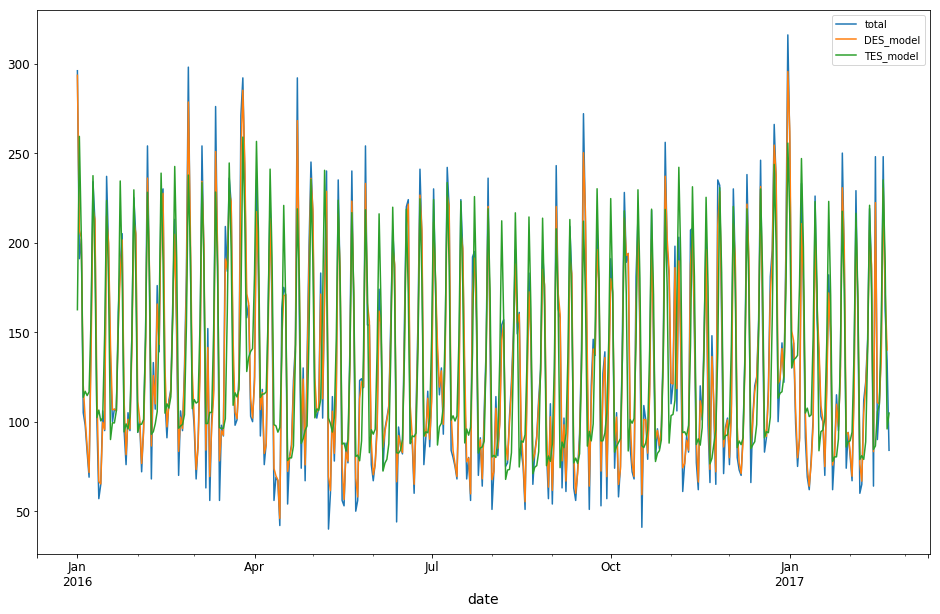

In [32]:
# Looking at the TES forecasts, 

train[['total','DES_model','TES_model']].plot(legend = True)

The Triple Exponential Smoothing model looks to perform better.

However, we can get a better view by zooming-in on a shorter time-horizon

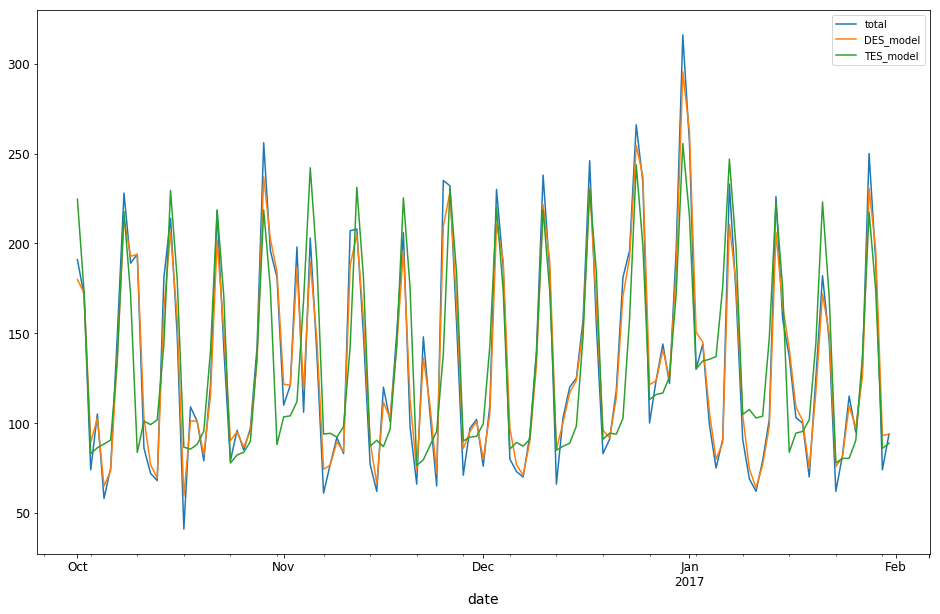

In [33]:
# Looking at the TES forecasts, zooming in to have a better look

train[['total','DES_model','TES_model']]['2016-10-01':'2017-1-31'].plot(legend = True)



#### Double and Triple Exponential Models: The Forecasts
To get a concete sense on how well the Holt's and Holt - Winter's models perform.

Next Step: Evaluating forecasts on test set using RMSE as the KPI


In [34]:
test_predictions_DES = fitted_model_DES.forecast(60)
test_predictions_TES = fitted_model_TES.forecast(60)

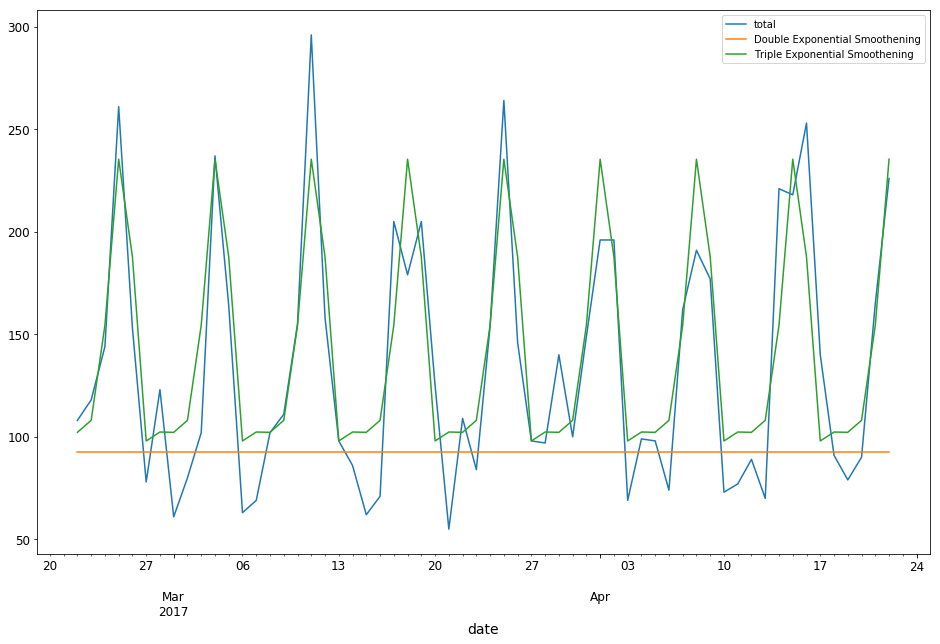

In [35]:
# Plotting Test predictions against the test set
test['total'].plot(legend = True)
test_predictions_DES.plot(legend = True, label = "Double Exponential Smoothening")
test_predictions_TES.plot(legend = True, label = "Triple Exponential Smoothening")

In [36]:
# Evaluating the RMSE for the Triple Exponential Smoothing Model

mse = mean_squared_error (test['total'],test_predictions_TES)

print(" RMSE for the Triple Exponential Smoothening Model : ", np.sqrt(mse))

 RMSE for the Triple Exponential Smoothening Model :  29.79322731595129


In [79]:
test['total'].describe()

count     60.000000
mean     134.400000
std       60.719472
min       55.000000
25%       85.500000
50%      114.500000
75%      168.000000
max      296.000000
Name: total, dtype: float64

On an absolute basis, the RMSE value of 29.79 **looks very good**, its much lesser than the mean and standard deviation of the `test['total']` the variable we are looking to forecast.

We can make a *decisive comment* on this post looking at the RMSE from training the SARIMAX model.


***

### 4. Exploring an SARIMA Based Approach

There are 2 distinct approaches for training an ARIMA based model, while the **classic approach** relies on reading ACF and P-ACF plots *(to ascertain AutoRegressive and Moving Average components)*, diferencing the series *(for making it stationary)* and performing Augmented Dickey Fuller test *(to check for stationarity)* , the **modern approach** uses GridSearch.

In my experience, I have found GridSearch to be more effective in determining the best set of hyperparamers for the ARIMA model.


#### Modern Approach to SARIMA - GridSearch

In [37]:

stepwise_fit = auto_arima(train['total'],
                          seasonal = True, trace = True, m=7)


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 7); AIC=4312.596, BIC=4344.880, Fit time=2.735 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=4607.450, BIC=4615.521, Fit time=0.021 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 7); AIC=4305.073, BIC=4321.215, Fit time=0.823 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 7); AIC=4410.287, BIC=4426.429, Fit time=0.301 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=4546.252, BIC=4558.359, Fit time=0.086 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 7); AIC=4250.615, BIC=4270.792, Fit time=2.219 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 7); AIC=4312.233, BIC=4336.446, Fit time=2.137 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 0, 7); AIC=4266.408, BIC=4282.550, Fit time=1.468 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 0, 7); AIC=4253.665, BIC=4277.878, Fit time=2.875 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 0, 7); AIC=4269.175, BIC=4293.387, Fit time=1.718 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(2, 0, 0, 7); AIC=4265.541, BIC=4293.789, Fit time=2.622 seconds
Total fit time: 17.108 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [38]:
# The best performing model is..

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  418
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2120.307
Date:                           Wed, 06 Nov 2019   AIC                           4250.615
Time:                                   17:46:29   BIC                           4270.792
Sample:                                        0   HQIC                          4258.591
                                           - 418                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     21.6491      4.774      4.535      0.000      12.292      31.006
ar.L1          0.2050      0.049      4.199      0.000       0.109       0.301
ar.S.L7        0.4273      0.040     10.715      0.000       0.349       0.505
ar.S.L14       0.3719      0.039      9.482      0.000       0.295       0.449
sigma2      1467.9408     94.508     15.532      0.000    1282.708    1653.173
===================================================================================
Ljung-Box (Q):                       63.96   Jarque-Bera (JB):                26.26
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.48
Prob(H) (two-sided):                  0.76   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Implementing Seasonal ARIMA model (SARIMA) and generating forecasts

In [40]:
# Implmenting SARIMA

model = SARIMAX(train['total'],order = (1,0,0), seasonal_order = (2,0,0,7))

result = model.fit()

In [42]:
# Generating Predictions

# Generating predictions
start = len(train)
end = len(train) + len(test) - 1

predictions_SARIMA = result.predict(start = start ,end = end, typ = 'levels')

#IMP: if you choose the default value of "typ" hyperparameter ( 'linear'). you'll get results in terms of differenced data

predictions_SARIMA = predictions_SARIMA.rename('SARIMA')

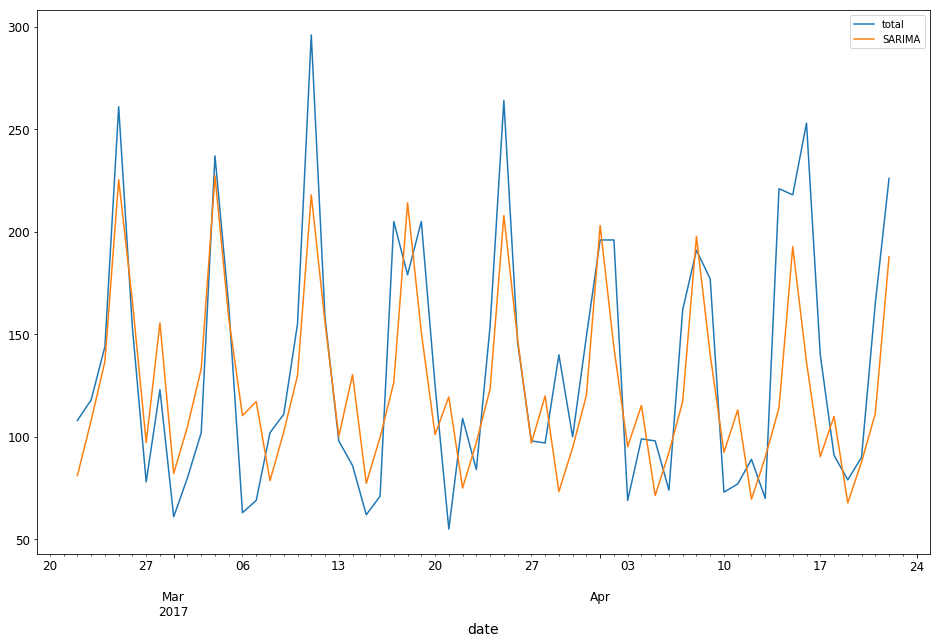

In [43]:
# Plotting test predictions and test data

test['total'].plot(legend = True)
predictions_SARIMA.plot(legend = True)


These predictions look **quite good**, calculating the RMSE next 

In [44]:
# Evaluating the performance of the model using MSE/RMSE

mse = mean_squared_error(test['total'], predictions_SARIMA)

#$print("Mean Squared Error (MSE) : ", mse,"\n")
print("RMSE : ", np.sqrt(mse))

RMSE :  38.88641117590279


#### Implementing SARIMA with Exogenous Variables

We'll include the 'holiday' variable as an exogenous factor to the predictions.

In [45]:
# Sarima with Exogenous variables

# Training an auto_arima model (EXO VERSION) to get the best set of parameters
# IMP: STATSMODELS EXPECTS A DATAFRAME IN THE EXOGENOUS VARIABLE HYPERPARAMETER, HENCE [[]]

stepwise_fit = auto_arima(train['total'],
                          exogenous = train[['holiday']],
                          seasonal = True, trace = True, m=7)


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 7); AIC=4463.164, BIC=4499.483, Fit time=2.173 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=4579.550, BIC=4591.657, Fit time=0.069 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 7); AIC=4193.806, BIC=4213.983, Fit time=1.534 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 7); AIC=4343.140, BIC=4363.317, Fit time=0.990 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=4522.289, BIC=4538.431, Fit time=0.349 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 7); AIC=4176.020, BIC=4200.232, Fit time=5.333 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 7); AIC=4299.159, BIC=4327.407, Fit time=2.610 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 0, 7); AIC=4144.792, BIC=4164.970, Fit time=2.201 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: order=(0, 0, 1) seasonal_order=(2, 0, 0, 7); AIC=4132.470, BIC=4156.683, Fit time=1.893 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(2, 0, 0, 7); AIC=4328.969, BIC=4361.253, Fit time=2.765 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 0, 7); AIC=4192.509, BIC=4212.686, Fit time=0.806 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1) seasonal_order=(2, 0, 1, 7); AIC=4223.393, BIC=4251.641, Fit time=2.203 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 0, 7); AIC=4153.163, BIC=4181.411, Fit time=2.144 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(2, 0, 0, 7); AIC=4160.444, BIC=4188.692, Fit time=2.025 seconds
Total fit time: 27.125 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [46]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  418
Model:             SARIMAX(0, 0, 1)x(2, 0, 0, 7)   Log Likelihood               -2060.235
Date:                           Wed, 06 Nov 2019   AIC                           4132.470
Time:                                   17:51:05   BIC                           4156.683
Sample:                                        0   HQIC                          4142.042
                                           - 418                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.6362      4.589      3.626      0.000       7.643      25.630
x1            68.5902      4.453     15.401      0.000      59.862      77.319
ma.L1          0.2208      0.050      4.440      0.000       0.123       0.318
ar.S.L7        0.4272      0.046      9.366      0.000       0.338       0.517
ar.S.L14       0.4307      0.043     10.127      0.000       0.347       0.514
sigma2      1083.8349     75.308     14.392      0.000     936.233    1231.436
===================================================================================
Ljung-Box (Q):                       83.79   Jarque-Bera (JB):                 2.25
Prob(Q):                              0.00   Prob(JB):                         0.33
Heteroskedasticity (H):               0.91   Skew:                             0.18
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
# Implementing SARIMAX

model = SARIMAX(train['total'],exog = train[['holiday']], order = (0,0,1), seasonal_order = (2,0,0,7))

result = model.fit()

In [48]:
# Generating Predictions

# Generating predictions
start = len(train)
end = len(train) + len(test) - 1

predictions_SARIMAX = result.predict(start = start ,end = end,exog = test[['holiday']], typ = 'levels')

#IMP: if you choose the default value of "typ" hyperparameter ( 'linear'). you'll get results in terms of differenced data

predictions_SARIMAX = predictions_SARIMAX.rename('SARIMAX (WITH exogenous var)')

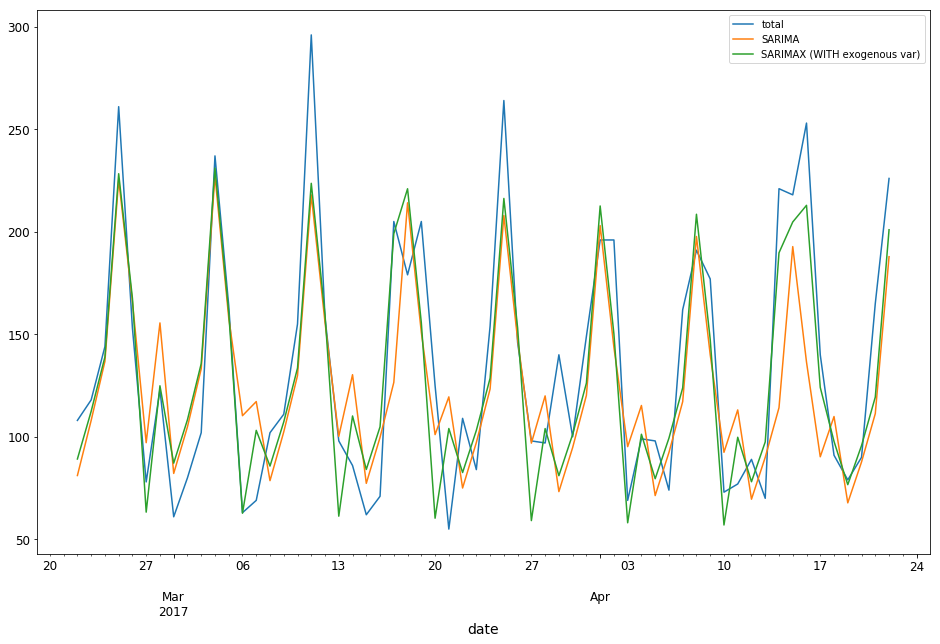

In [49]:
# Plotting test predictions and test data

test['total'].plot(legend = True)
predictions_SARIMA.plot(legend = True)
predictions_SARIMAX.plot(legend = True)


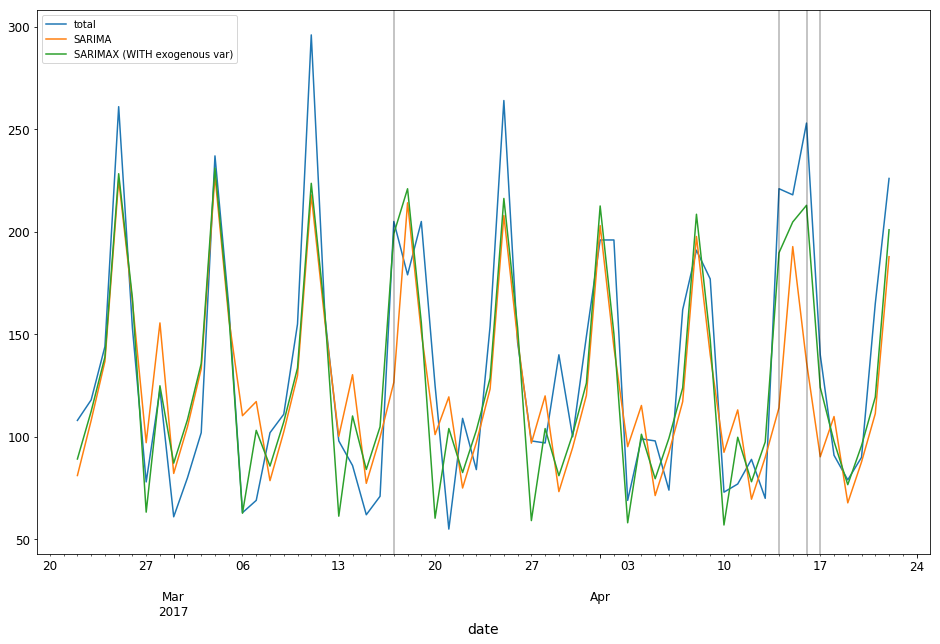

In [50]:
# viewing the holiday variable too - VERY USEFUL PIECE OF CODE

ax= test['total'].plot(legend = True)
predictions_SARIMA.plot(legend = True)
predictions_SARIMAX.plot(legend = True)

for day in test.query('holiday ==1').index:
    ax.axvline(x=day, color = 'black', alpha = 0.3);

In [51]:
# Calculating the RMSE for the SARIMA model

mse = mean_squared_error(test['total'], predictions_SARIMAX)

#$print("Mean Squared Error (MSE) : ", mse,"\n")
print("RMSE : ", np.sqrt(mse))

RMSE :  28.65992025564127


The model does much better than the vanilla SARIMA model, the predictions for the holidays are **much more accurate** than before.

***

### 5. Summary


SARIMAX is the best performing model *(RMSE of 28.65)* followed by Holt-Winters model *(RMSE of 29.79)*
